In [2]:
import torch
from scipy.io import loadmat
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch import nn
from tkinter import filedialog
import tkinter as tk
from neurorobotics_dl.utils import MyDataset,summary,get_class
from neurorobotics_dl.trainer import MyTrainer

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,f1_score
import matplotlib.pyplot as plt

import os
from neurorobotics_dl.processing import read_gdf, filter_data
from joblib import dump,load
from datetime import date,time

class Event():
    START = 1
    CONT_FEEDBACK = 781
    FIXATION = 786
    HIT = 897
    MISS = 898
    TIMEOUT = 899
    REST = 700
    LEFT_ALIGNMENT_STEP = 701
    LEFT_STEP = 702
    RIGHT_ALIGNMENT_STEP = 703
    RIGHT_STEP = 704
    MOVEMENT_START = 333
    BOTH_HANDS = 773
    BOTH_FEET = 771
    REST = 783

    OFFSET = 0X8000

def select_files(initialdir='./recordings'):
    root = tk.Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    filenames = []
    while True:
       new_names = filedialog.askopenfilenames(initialdir=initialdir,defaultextension='gdf')
       if not new_names:
           break
       filenames.extend(new_names) 
    return filenames

def create_windows(eeg, events, window_size, window_shift,start_after = 0,end_before = 0):
    windows,winlabels = [],[]
    for _,row in tqdm(events.iterrows(),leave=False,total=len(events)):
        start,stop = row['POS'] + start_after, row['POS']+row['DUR'] - end_before
        if type(window_shift) == dict:
            shift = window_shift[row['label']]
        else: 
            shift = window_shift
        while start+window_size < stop:
            winlabels.append(row['label'])
            windows.append(eeg[start:start+window_size])
            start+=shift
    windows = np.stack(windows)
    windows = torch.from_numpy(windows).float().unsqueeze(1).permute(0,1,3,2)  
    winlabels = torch.tensor(winlabels).long()

    return windows,winlabels

def predict_all(model,dataloader,device):
    model.eval()

    model.to(device)
    logits = []
    labels = []
    with torch.no_grad():
            
        for x,y in tqdm(dataloader):
            x = x.to(device)
            out = model(x)
            logits.append(out)
            labels.append(y)
        logits = torch.vstack(logits).cpu().numpy()
        labels = torch.cat(labels).cpu().numpy()
        return logits,labels

def show_results(model,dataloader,device,criterion=torch.nn.CrossEntropyLoss(),ax=None):
    logits,labels = predict_all(model,dataloader,device)
    acc = (logits.argmax(axis=1) == labels).mean()
    loss = criterion(torch.from_numpy(logits),torch.from_numpy(labels)).item()
    f1 = f1_score(labels,logits.argmax(axis=1),average='macro')
    print("F1: {:.2f}% | Acc: {:.2f}% | Loss: {}".format(f1*100,acc*100,loss))
    cm = confusion_matrix(labels,logits.argmax(axis=1))
    ConfusionMatrixDisplay(cm).plot(ax=ax)


def preprocess(filenames,save_path=None):
    eegs = []
    all_events = []
    last_eeg_len = 0
    fileno = 0
    for filename in filenames:        
        try:

            tqdm.write(str(fileno)+ " - "+ filename.split('/')[-2]+" - "+filename.split('/')[-1], end = ' - ')
            extras = filename.split('/')[-1].split('.')
            
            
            recording = read_gdf(filename,drop_chans=['sens1','Status','trigger:1'])
            
            eeg = recording['data']
            info = recording['info']
            subj = info['subject_info']['his_id']
            dat = info['meas_date']
            mode = extras[3]
            protocol = extras[4]
            fs = info['sfreq'] 
            events = recording['events']

            eeg = filter_data(eeg, fs,fc_bp=[2,40])
            events['POS'] += last_eeg_len
            events['FILENO'] = fileno
            events['FILENAME'] = filename.split('/')[-1]
            events['SUBJ'] = subj
            events['DATE'] = dat
            events['MODE'] = mode
            events['PROTOCOL'] = protocol

        except Exception as e:
            print(f"Error: {e} - Skipping file..")
            continue

        eegs.append(eeg)
        fileno += 1
        all_events.append(events)
        last_eeg_len += len(eeg)
        print("Loaded.")
        
    eegs = np.concatenate(eegs)
    all_events = pd.concat(all_events)

    preprocessed = {'data':eegs,
                    'events':all_events,
                    'info': info
                }
    
    if save_path is not None:
        if not os.path.isdir(save_path):
            os.mkdir(save_path)
        dump(preprocessed,os.path.join(save_path,f'preprocessed.pkl'))
    
    
    return preprocessed

In [3]:
MANUAL_PICK = False
SAVE_PATH=r'D:\SHARED\PhD\code\python\cache'
if MANUAL_PICK:
    filenames = select_files(r'D:\SHARED\PhD\data\mi_bhbf')
    if not filenames:
        print('No files selected! Nothing to preprocess!')
    else: dataset = preprocess(filenames,SAVE_PATH)
else:
    dataset = load(os.path.join(SAVE_PATH,f"preprocessed.pkl"))

In [4]:
out_path = "generic_wheel"

train_batch_size = 128
eval_batch_size = 256
device = 'cuda'

label_map = { # PUT ALL THE CUE CODES HERE OTHERWISE IT FAILS, -1 TO IGNORE  
  730: 0,   # CVSA LEFT 
  731: 1,   # CVSA RIGHT
  771: -1,  # BOTH_FEET
  773: -1,  # BOTH_HANDS
  769: -1,  # LEFT_HAND
  770: -1,  # RIGHT_HAND
  783: -1   # REST
  }
num_classes = np.unique(list(label_map.values())).shape[0]
window_size = 512
window_shift = {
    0:32,
    1:32,
  }
start_after = 256
end_before = 256

eeg = dataset['data']

# from neurorobotics_dl.utils import fidx
# ROI = ['P3','PZ','P4','PO7','PO5','PO3','POZ','PO4','PO6','O1','OZ','O2']
# eeg = eeg[:,fidx(ROI, dataset['info']['ch_names'])]


events = dataset['events']
num_channels = eeg.shape[1]

labels = events['TYP'].map(label_map).dropna().values.astype(int)


cf_events = events[events['TYP'] == Event.CONT_FEEDBACK].copy()
cf_events['label'] = labels
cf_events = cf_events[cf_events['label'] >= 0].reset_index(drop=True)
cf_events

,TYP,POS,DUR,FILENO,FILENAME,SUBJ,DATE,MODE,PROTOCOL,label
0,781,4155,2365,0,c7.20260130.154152.calibration.cvsa_lbrb.gdf,c7,2026-01-30 14:41:53.000002+00:00,calibration,cvsa_lbrb,1
1,781,9388,2138,0,c7.20260130.154152.calibration.cvsa_lbrb.gdf,c7,2026-01-30 14:41:53.000002+00:00,calibration,cvsa_lbrb,1
2,781,14394,2727,0,c7.20260130.154152.calibration.cvsa_lbrb.gdf,c7,2026-01-30 14:41:53.000002+00:00,calibration,cvsa_lbrb,0
3,781,19989,2403,0,c7.20260130.154152.calibration.cvsa_lbrb.gdf,c7,2026-01-30 14:41:53.000002+00:00,calibration,cvsa_lbrb,1
4,781,25260,2635,0,c7.20260130.154152.calibration.cvsa_lbrb.gdf,c7,2026-01-30 14:41:53.000002+00:00,calibration,cvsa_lbrb,1
...,...,...,...,...,...,...,...,...,...,...
135,781,772552,1870,6,c7.20260130.161842.evaluation.cvsa_lbrb.buffer...,c7,2026-01-30 15:18:41.999989+00:00,evaluation,cvsa_lbrb,0
136,781,777289,3024,6,c7.20260130.161842.evaluation.cvsa_lbrb.buffer...,c7,2026-01-30 15:18:41.999989+00:00,evaluation,cvsa_lbrb,1
137,781,783181,3276,6,c7.20260130.161842.evaluation.cvsa_lbrb.buffer...,c7,2026-01-30 15:18:41.999989+00:00,evaluation,cvsa_lbrb,0
138,781,789324,2219,6,c7.20260130.161842.evaluation.cvsa_lbrb.buffer...,c7,2026-01-30 15:18:41.999989+00:00,evaluation,cvsa_lbrb,0


In [5]:
## Choose one between 70-15-15 split or manual selecting files. comment the other

## 70-15-15 split
#train_files = range(len(filenames))
#train_events = trial_events[trial_events['FILENO'].isin(train_files)]
#val_events = train_events[int(len(train_events)*0.7):int(len(train_events)*0.85)]
#test_events = train_events[int(len(train_events)*0.85):]
#train_events = train_events[:int(len(train_events)*0.7)]

# ## Separate sessions
train_files = [0,1,2]
val_files = [3]
test_files = [4,5,6]
train_events = cf_events[cf_events['FILENO'].isin(train_files)]
val_events = cf_events[cf_events['FILENO'].isin(val_files)]
test_events = cf_events[cf_events['FILENO'].isin(test_files)]


#Create datasets and dataloaders
train_w,train_l = create_windows(eeg, train_events, window_size, window_shift,start_after,end_before)
val_w,val_l = create_windows(eeg, val_events, window_size, window_shift,start_after,end_before)
test_w,test_l = create_windows(eeg, test_events, window_size, window_shift,start_after,end_before)

# Apply standardization
mu,sigma = train_w.mean(axis = (0,1,3),keepdims=True),train_w.std(axis = (0,1,3),keepdims=True)
train_w = (train_w - mu) / sigma
val_w = (val_w - mu) / sigma
test_w = (test_w - mu) / sigma

if not os.path.exists(out_path):
    os.makedirs(out_path)
np.savez(os.path.join(out_path,"mean_std.npz"),mu=mu,sigma=sigma)

for e in (torch.unique(train_l,return_counts=True),
torch.unique(val_l,return_counts=True),
torch.unique(test_l,return_counts=True)): print(e)

train_loader = DataLoader(MyDataset(train_w,train_l), batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(MyDataset(val_w,val_l), batch_size=eval_batch_size, shuffle=False)
test_loader = DataLoader(MyDataset(test_w,test_l), batch_size=eval_batch_size, shuffle=False)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

(tensor([0, 1]), tensor([1387, 1322]))
(tensor([0, 1]), tensor([599, 391]))
(tensor([0, 1]), tensor([1793, 1286]))


In [6]:
# # EEGNET
model_config = {
  'classname': 'neurorobotics_dl.models.EEGNet',
  'options': {
    'nb_classes': num_classes,
    'Chans': num_channels,
    'Samples': window_size,
    'dropoutRate': 0.5,
    'kernLength': window_size//2,
    'F1': 8,
    'D': 2,
    'F2': 16
  }
}


# # TGCN
# model_config = {
#   'classname': 'neurorobotics_dl.models.GCN_GRU_sequence_fxdD',
#   'options': { 'num_channels': num_channels,
#                'gcn_input_dim' : num_channels,
#                'num_classes' : num_classes,
#                'gcn_output_dim' : 16,
#                'gru_hidden_units' : 16,
#                'gcn_dropout' : 0.3,
#                'gru_dropout' : 0.3
#   }
# }

# # GRU
# model_config = {
#   'classname': 'models.RNN',
#   'options': { 'input_size': 32,
#                'num_classes' : num_classes,
#                'hidden_size' : 128,
#                'num_layers' : 1,
#   }
# }

# # PhiNet
# model_config = {
#   'classname': ' micromind.networks.PhiNet',
#   'options': {'input_shape':(1, num_channels, window_size),
#                'num_classes':num_classes,
#                'num_layers' : 6,
#                'alpha':0.5,
#                'beta':2,
#                't_zero':1.5,
#                'include_top':True
# }
# }

# # AttentionNet
# model_config = {
#   'classname': 'models.AttentionNet',
#   'options': { 'num_channels':32,
#                'num_classes':num_classes,
#                'num_heads':1,
#                'hidden_size':128,
#                'enforce_simmetry':True
#   }
# }

# # EEGTransformer
# model_config = {
#   'classname': 'neurorobotics_dl.models.EEGTransformer',
#   'options': { 'd_model' : 32, 
#               'embedding_dim' : 2, 
#               'encoder_layer_args':{'nhead':4,'batch_first':True},
#               'encoder_args':{'num_layers':2},
#   }
# }


model = get_class(model_config['classname'])(**model_config['options']).to(device)

summary(model)
class WeightClipper(object):
    def __call__(self, module):
        # filter the variables to get the ones you want
        if hasattr(module, 'Wa'):
            module.Wa.data.clamp_(0,1)

Model Parameters:
+-------------------+--------+-----------------------------+-----------+
|       Layer       | Params |            Shape            | Trainable |
+-------------------+--------+-----------------------------+-----------+
|    conv.weight    |  2048  |  torch.Size([8, 1, 1, 256]) |    True   |
|     bn1.weight    |   8    |       torch.Size([8])       |    True   |
|      bn1.bias     |   8    |       torch.Size([8])       |    True   |
| depth_conv.weight |  256   |  torch.Size([16, 1, 16, 1]) |    True   |
|     bn2.weight    |   16   |       torch.Size([16])      |    True   |
|      bn2.bias     |   16   |       torch.Size([16])      |    True   |
| point_conv.weight |  4096  | torch.Size([16, 16, 1, 16]) |    True   |
|     bn3.weight    |   16   |       torch.Size([16])      |    True   |
|      bn3.bias     |   16   |       torch.Size([16])      |    True   |
|     fc.weight     |  768   |     torch.Size([3, 256])    |    True   |
|      fc.bias      |   3    |   

In [7]:
from torch.optim import Adam,AdamW,SGD
from neurorobotics_dl.losses import AdaptiveFocalLoss
model = get_class(model_config['classname'])(**model_config['options']).to(device)


optimizer = Adam(model.parameters(),lr = 0.001,weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,1,0.1,100)
# criterion = nn.CrossEntropyLoss()
criterion = AdaptiveFocalLoss()


model = model.to(device)
"""   TRAIN   """
trainer = MyTrainer(model,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    es_patience=0,
                    es_min_delta=0,
                    # contraints=WeightClipper()
                    )

trainer.train( 60,
                criterion,
                train_loader,
                val_loader,
                logger_name=os.path.join(out_path,"training.log"),
                device = device,
                path=out_path,
                )

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/60	 Train Loss: 0.4350167910037951, Train Acc: 0.44850498360872887, Val Loss: 0.3656280814397215, Val Acc: 0.4898989874907214
New best loss achieved: 0.3656280814397215


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2/60	 Train Loss: 0.2697194211539768, Train Acc: 0.5119970469137715, Val Loss: 0.2671188298499945, Val Acc: 0.4919191950499409
New best loss achieved: 0.2671188298499945


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3/60	 Train Loss: 0.22030789766222755, Train Acc: 0.5190107052332363, Val Loss: 0.22121177941861778, Val Acc: 0.4858585829686637
New best loss achieved: 0.22121177941861778


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4/60	 Train Loss: 0.2068193442060658, Train Acc: 0.5116279070097479, Val Loss: 0.20004726341276458, Val Acc: 0.5292929378422824
New best loss achieved: 0.20004726341276458


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5/60	 Train Loss: 0.19708025641945642, Train Acc: 0.5116279071527639, Val Loss: 0.1912032171933338, Val Acc: 0.4696969747543335
New best loss achieved: 0.1912032171933338


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6/60	 Train Loss: 0.1900081517028386, Train Acc: 0.5223329643474465, Val Loss: 0.1876888784495267, Val Acc: 0.5050505095058018
New best loss achieved: 0.1876888784495267


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7/60	 Train Loss: 0.1863475587918953, Train Acc: 0.5267626432617374, Val Loss: 0.18246427328899653, Val Acc: 0.5454545487057079
New best loss achieved: 0.18246427328899653


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8/60	 Train Loss: 0.18363450721714847, Train Acc: 0.5459579182709658, Val Loss: 0.17839142514599693, Val Acc: 0.603030309291801
New best loss achieved: 0.17839142514599693


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9/60	 Train Loss: 0.18218260832975253, Train Acc: 0.5422665190437087, Val Loss: 0.17686040786781695, Val Acc: 0.5909090899457835
New best loss achieved: 0.17686040786781695


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10/60	 Train Loss: 0.17661662718254334, Train Acc: 0.574381690880785, Val Loss: 0.17418356787676764, Val Acc: 0.624242428697721
New best loss achieved: 0.17418356787676764


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11/60	 Train Loss: 0.17500173580210868, Train Acc: 0.579180509479075, Val Loss: 0.17035699143554225, Val Acc: 0.6131313237276944
New best loss achieved: 0.17035699143554225


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12/60	 Train Loss: 0.17466803254809227, Train Acc: 0.5861941677875385, Val Loss: 0.16964294461890905, Val Acc: 0.5787878797511862
New best loss achieved: 0.16964294461890905


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13/60	 Train Loss: 0.1737757197283167, Train Acc: 0.5991140644283653, Val Loss: 0.16980043803200578, Val Acc: 0.6454545450933051


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14/60	 Train Loss: 0.17025850732505168, Train Acc: 0.603912883202675, Val Loss: 0.16733071767922603, Val Acc: 0.6424242463978854
New best loss achieved: 0.16733071767922603


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15/60	 Train Loss: 0.16938146513715888, Train Acc: 0.6164636398954733, Val Loss: 0.1669522972118975, Val Acc: 0.650505048939676
New best loss achieved: 0.1669522972118975


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16/60	 Train Loss: 0.1676656049571384, Train Acc: 0.6216315984087881, Val Loss: 0.16664313433146236, Val Acc: 0.6565656665599707
New best loss achieved: 0.16664313433146236


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17/60	 Train Loss: 0.16529504139073972, Train Acc: 0.6330749355765364, Val Loss: 0.16614559645002538, Val Acc: 0.6474747472339206
New best loss achieved: 0.16614559645002538


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18/60	 Train Loss: 0.16369369984135146, Train Acc: 0.6386120341808957, Val Loss: 0.1665442781014876, Val Acc: 0.6444444472139532


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19/60	 Train Loss: 0.16692660752809016, Train Acc: 0.6275378370381844, Val Loss: 0.16844401136793272, Val Acc: 0.6141414241357284


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20/60	 Train Loss: 0.16119183296865094, Train Acc: 0.6574381692640981, Val Loss: 0.16385770849507264, Val Acc: 0.6303030342766733
New best loss achieved: 0.16385770849507264


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21/60	 Train Loss: 0.16224082815400698, Train Acc: 0.642303433177127, Val Loss: 0.16449775876420916, Val Acc: 0.6474747514483905


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22/60	 Train Loss: 0.15954608438022905, Train Acc: 0.6611295682163245, Val Loss: 0.16315433966993081, Val Acc: 0.635353542337514
New best loss achieved: 0.16315433966993081


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23/60	 Train Loss: 0.1549000581633609, Train Acc: 0.6736803249311254, Val Loss: 0.16764464465656667, Val Acc: 0.5797979885881598


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24/60	 Train Loss: 0.15683445281628622, Train Acc: 0.6758951644432769, Val Loss: 0.16261110092052306, Val Acc: 0.6272727323300911
New best loss achieved: 0.16261110092052306


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25/60	 Train Loss: 0.15857637433514643, Train Acc: 0.6718346254550122, Val Loss: 0.16488202719977407, Val Acc: 0.6030303110980024


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26/60	 Train Loss: 0.15776972590380817, Train Acc: 0.6555924697219775, Val Loss: 0.16579581776050606, Val Acc: 0.586868691444397


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27/60	 Train Loss: 0.15235647576767916, Train Acc: 0.6910299005082455, Val Loss: 0.16539571712715456, Val Acc: 0.5919191932437395


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28/60	 Train Loss: 0.15424611218391904, Train Acc: 0.678848283631461, Val Loss: 0.16550260390898194, Val Acc: 0.6050505105895225


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29/60	 Train Loss: 0.1564588508138625, Train Acc: 0.6795865634835132, Val Loss: 0.1635337688706138, Val Acc: 0.6050505033647171


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30/60	 Train Loss: 0.15310324921560445, Train Acc: 0.6891842009441225, Val Loss: 0.1638803286082817, Val Acc: 0.6262626233727041


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 31/60	 Train Loss: 0.15341005702329413, Train Acc: 0.6895533408701486, Val Loss: 0.16273404064804617, Val Acc: 0.6272727378691085


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 32/60	 Train Loss: 0.14898634530073077, Train Acc: 0.7061646365512118, Val Loss: 0.1624672026345224, Val Acc: 0.6171717178941977
New best loss achieved: 0.1624672026345224


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 33/60	 Train Loss: 0.15257130610014338, Train Acc: 0.6866002216379595, Val Loss: 0.1676675776640574, Val Acc: 0.5838383870895463


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 34/60	 Train Loss: 0.15098645865378146, Train Acc: 0.6891842009221201, Val Loss: 0.16185676744489957, Val Acc: 0.6202020215265679
New best loss achieved: 0.16185676744489957


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 35/60	 Train Loss: 0.14865847110154226, Train Acc: 0.7046880768911123, Val Loss: 0.1625111374590132, Val Acc: 0.647474754458726


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 36/60	 Train Loss: 0.14569243248008898, Train Acc: 0.7168696937898993, Val Loss: 0.16427244833021454, Val Acc: 0.6181818208309136


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 37/60	 Train Loss: 0.14576483305836568, Train Acc: 0.7172388336279155, Val Loss: 0.16334987427249098, Val Acc: 0.6252525260954193


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 38/60	 Train Loss: 0.14517372319094587, Train Acc: 0.7198228130660932, Val Loss: 0.16240519279181356, Val Acc: 0.6373737368920837


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 39/60	 Train Loss: 0.15160095207626945, Train Acc: 0.705426356721162, Val Loss: 0.16018385793825593, Val Acc: 0.5868686844604184
New best loss achieved: 0.16018385793825593


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 40/60	 Train Loss: 0.14483358006650734, Train Acc: 0.7249907716124117, Val Loss: 0.164887250222341, Val Acc: 0.6090909129441386


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 41/60	 Train Loss: 0.14640730236862892, Train Acc: 0.709856035547443, Val Loss: 0.16022343180998408, Val Acc: 0.6303030286172424


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 42/60	 Train Loss: 0.14759622556052554, Train Acc: 0.7065337764552353, Val Loss: 0.16141440212124525, Val Acc: 0.5838383937122846


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 43/60	 Train Loss: 0.13968811742480103, Train Acc: 0.7375415283272124, Val Loss: 0.1634513709280226, Val Acc: 0.5989899033247822


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 44/60	 Train Loss: 0.14271657311331087, Train Acc: 0.721299372550173, Val Loss: 0.15953056989896178, Val Acc: 0.6313131314335447
New best loss achieved: 0.15953056989896178


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 45/60	 Train Loss: 0.1404166300607458, Train Acc: 0.7434477668796002, Val Loss: 0.1684983888358781, Val Acc: 0.5808080834571762


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 46/60	 Train Loss: 0.14123758076026283, Train Acc: 0.7320044298328654, Val Loss: 0.1585999615565695, Val Acc: 0.634343438798731
New best loss achieved: 0.1585999615565695


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 47/60	 Train Loss: 0.13914668106227487, Train Acc: 0.7360649687551228, Val Loss: 0.1643640249365508, Val Acc: 0.6646464722325104


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 48/60	 Train Loss: 0.14137927309399206, Train Acc: 0.7216685125422064, Val Loss: 0.159657143041341, Val Acc: 0.6282828363505277


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 49/60	 Train Loss: 0.13967888414221702, Train Acc: 0.7305278702607758, Val Loss: 0.15969325153514594, Val Acc: 0.6404040477492593


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 50/60	 Train Loss: 0.1402112353646742, Train Acc: 0.7283130307706267, Val Loss: 0.1667264467839039, Val Acc: 0.6363636391331451


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 51/60	 Train Loss: 0.13834593382630678, Train Acc: 0.7441860466876475, Val Loss: 0.15911171041955852, Val Acc: 0.5979798030371618


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 52/60	 Train Loss: 0.13491763129428816, Train Acc: 0.7526762644141836, Val Loss: 0.15811100048248214, Val Acc: 0.6424242402568008
New best loss achieved: 0.15811100048248214


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 53/60	 Train Loss: 0.1400113783229449, Train Acc: 0.7467700259498056, Val Loss: 0.1579856906575386, Val Acc: 0.5939393965884893
New best loss achieved: 0.1579856906575386


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 54/60	 Train Loss: 0.13623906608193773, Train Acc: 0.7419712072195008, Val Loss: 0.15803983611891967, Val Acc: 0.621212121452948


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 55/60	 Train Loss: 0.13798604077763027, Train Acc: 0.7390180879873118, Val Loss: 0.17322269003800672, Val Acc: 0.5979798025555081


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 56/60	 Train Loss: 0.13767275914973376, Train Acc: 0.7438169066956141, Val Loss: 0.16055299188151503, Val Acc: 0.5979798024350946


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 57/60	 Train Loss: 0.13544854949699112, Train Acc: 0.7534145442662357, Val Loss: 0.16978777502522324, Val Acc: 0.6414141392466998


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 58/60	 Train Loss: 0.13457077467692385, Train Acc: 0.757475083232498, Val Loss: 0.15389399694071876, Val Acc: 0.6757575753963355
New best loss achieved: 0.15389399694071876


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 59/60	 Train Loss: 0.13150173694654424, Train Acc: 0.7578442230925168, Val Loss: 0.16102540005337107, Val Acc: 0.6303030305438572


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 60/60	 Train Loss: 0.13484344697990908, Train Acc: 0.7604282023326723, Val Loss: 0.15675268308682874, Val Acc: 0.6141414235336612


Train: 


C:\Users\tomma\AppData\Local\Temp\ipykernel_27684\1491917896.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(out_path,"Best

  0%|          | 0/22 [00:00<?, ?it/s]

F1: 86.48% | Acc: 86.49% | Loss: 0.5420789122581482
Val: 


  0%|          | 0/4 [00:00<?, ?it/s]

F1: 66.67% | Acc: 67.58% | Loss: 0.6311818361282349
Test: 


  0%|          | 0/13 [00:00<?, ?it/s]

F1: 60.34% | Acc: 60.93% | Loss: 0.6676697134971619


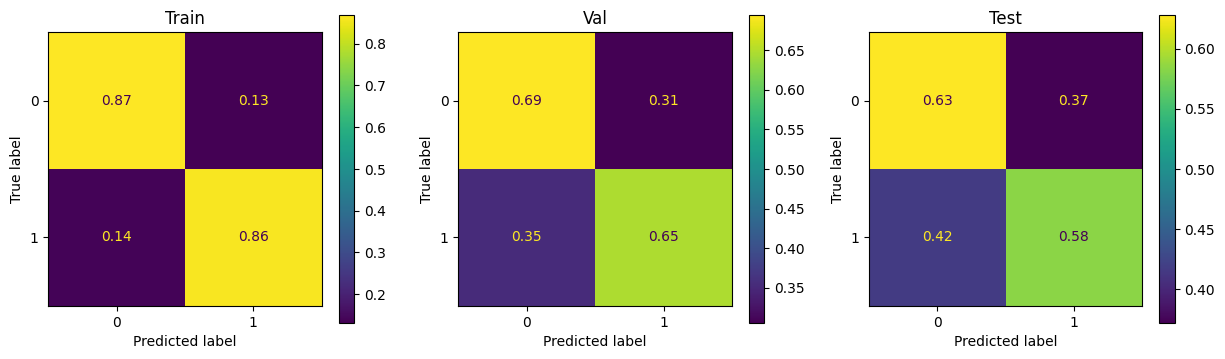

In [8]:
model.load_state_dict(torch.load(os.path.join(out_path,"BestModel/best-model.pt"))['model' ])
fig,(ax1,ax2,ax3) = plt.subplots(1,3)
fig.set_size_inches(15, 4)

def show_results(model,dataloader,device,criterion=torch.nn.CrossEntropyLoss(),ax=None):
    logits,labels = predict_all(model,dataloader,device)
    acc = (logits.argmax(axis=1) == labels).mean()
    loss = criterion(torch.from_numpy(logits),torch.from_numpy(labels)).item()
    f1 = f1_score(labels,logits.argmax(axis=1),average='macro')
    print("F1: {:.2f}% | Acc: {:.2f}% | Loss: {}".format(f1*100,acc*100,loss))
    cm = confusion_matrix(labels,logits.argmax(axis=1),normalize='true')
    ConfusionMatrixDisplay(cm).plot(ax=ax)

print("Train: "),show_results(model,train_loader,device,ax=ax1)
print("Val: "),show_results(model,val_loader,device,ax=ax2)
print("Test: "),show_results(model,test_loader,device,ax=ax3)
ax1.set_title("Train")
ax2.set_title("Val")
ax3.set_title("Test")

plt.show()

In [9]:
state_dict = torch.load(os.path.join(out_path,"BestModel/best-model.pt"))
mu_sigma = np.load(os.path.join(out_path,"mean_std.npz"))
state_dict['mu'] = mu
state_dict['sigma'] = sigma
state_dict['config'] = model_config
state_dict['classes'] = label_map
state_dict['filenames'] = cf_events[cf_events['FILENO'].isin(train_files)]['FILENAME'].drop_duplicates().values
torch.save(state_dict,os.path.join(out_path,f"{out_path}.pt"))

C:\Users\tomma\AppData\Local\Temp\ipykernel_27684\2808391836.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(out_path,"BestModel/bes

## Analysis

In [19]:
from neurorobotics_dl.utils import load_checkpoint

model_path = os.path.join(out_path,f'{out_path}.pt')
# model_path = '/home/whiteam/Desktop/exo_training/c8_exo/c8_exo.pt'
# state_dict = torch.load(model_path)

load_checkpoint(model_path)
model = get_class(state_dict['config']['classname'])(**state_dict['config']['options'])
model.load_state_dict(state_dict['model'])
mu,sigma = state_dict['mu'],state_dict['sigma']

D:\SHARED\PhD\code\python\neurorobotics-dl\neurorobotics_dl\utils.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = load(model_ckpt)


In [20]:
all_logits = []
all_labels = []
dfs = []
device = 'cuda'
eval_batch_size = 512

window_size = 512
window_shift = 16

t_events = cf_events[cf_events['FILENO'].isin([3])]
t_events = cf_events

for fileno in t_events['FILENO'].unique():
    print(fileno)
    ev = t_events[t_events['FILENO']==fileno]

    test_w,test_l = create_windows(eeg, ev, window_size, window_shift)
    test_w = (test_w - mu) / sigma
    test_loader = DataLoader(MyDataset(test_w,test_l), batch_size=eval_batch_size, shuffle=False)
    logits,labels = predict_all(model,test_loader,device)

    df = pd.DataFrame({'logits':logits.tolist(),
                       'preds':logits.argmax(axis=1).tolist(),
                       'labels':labels.tolist()})
    df['FILENO'] = fileno
    df['MODE'] = ev['MODE'].iloc[0]
    dfs.append(df)

results = pd.concat(dfs)

0


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

1


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

2


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

3


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

4


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

5


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

6


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

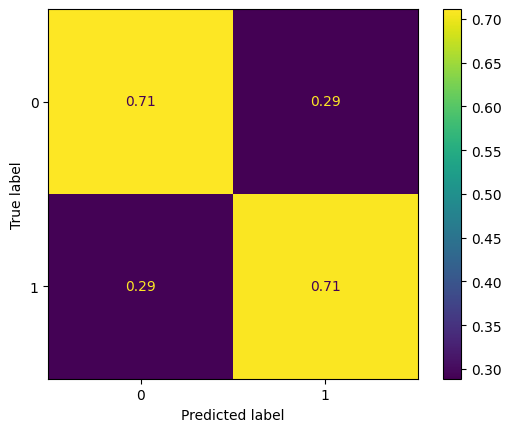

In [21]:
ConfusionMatrixDisplay(confusion_matrix(results['labels'],results['preds'],normalize='true')).plot()

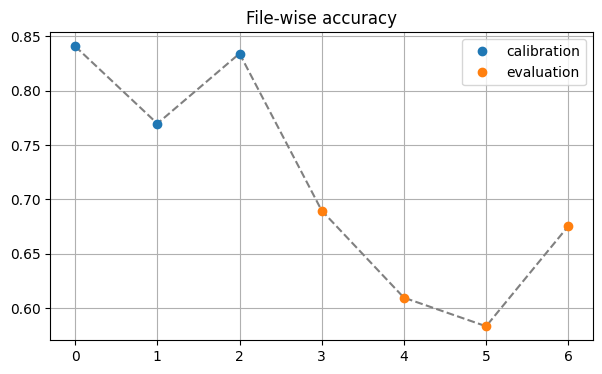

In [22]:
results['correct'] = results['labels'] == results['preds']
acc = results.groupby('FILENO')['correct'].mean().values

modes = results.groupby('FILENO').first()['MODE'].values


files = results.groupby('FILENO')['FILENO'].first().values
plt.figure(figsize=(7,4))
plt.title('File-wise accuracy')
plt.plot(files,acc,linestyle='--',color='gray')
for mode in np.unique(modes):
    plt.plot(files[modes==mode],acc[modes==mode],marker='o',linestyle='None',label=f'{mode}')
plt.xticks(files,files)
plt.grid()
plt.legend()
plt.show()

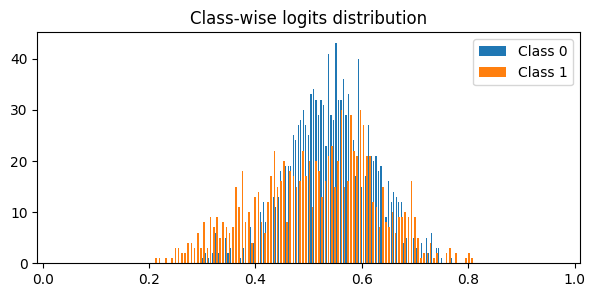

In [23]:
res = results[results.FILENO==5]
all_logits = np.stack(res['logits'].values)[:,:2]
# all_logits = minmax_scale(all_logits)
all_logits = torch.softmax(torch.from_numpy(all_logits),1).numpy()
# all_logits = (all_logits-(np.min(all_logits,axis=0)))/(np.max(all_logits,axis=0)-np.max(all_logits,axis=0))
labels = res['labels']

plt.figure(figsize=(7,3))
for i in range(all_logits.shape[1]):
    plt.hist(all_logits[labels==i][:,0],bins=100,rwidth=0.5,label=f'Class {i}')
plt.title('Class-wise logits distribution')
plt.legend()
plt.xlim(-0.01,1.01)
plt.show()